In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
!pip install scikit-learn==1.3.0


We use the older and stable version of sckikit for the sole purpose of its compatibility with XGB

---



In [4]:
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Renewable_Energy_Usage_Sampled.csv to Renewable_Energy_Usage_Sampled (1).csv


In [6]:
df= pd.read_csv('Renewable_Energy_Usage_Sampled.csv')

In [7]:
df.head()

,Household_ID,Region,Country,Energy_Source,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Urban_Rural,Adoption_Year,Subsidy_Received,Cost_Savings_USD
0,H01502,North America,USA,Hydro,1043.49,2024,5,Low,Urban,2012,No,10.46
1,H02587,Australia,Australia,Geothermal,610.01,2024,4,High,Rural,2023,No,43.49
2,H02654,North America,USA,Biomass,1196.75,2024,8,Low,Rural,2017,Yes,93.28
3,H01056,South America,Colombia,Biomass,629.67,2024,7,High,Urban,2023,No,472.85
4,H00706,Africa,Egypt,Hydro,274.46,2022,7,Middle,Rural,2010,No,65.98


# Basic Info

In [8]:
print("\nDataset Info:")
print("-" * 50)
print(df.info())

print("\nBasic Statistics:")
print("-" * 50)
print(df.describe())

print("\nMissing Values:")
print("-" * 50)
print(df.isnull().sum())

print("\nUnique Values in Categorical Columns:")
print("-" * 50)
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\n{col}:")
    print(df[col].value_counts())


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Household_ID       1000 non-null   object 
 1   Region             1000 non-null   object 
 2   Country            1000 non-null   object 
 3   Energy_Source      1000 non-null   object 
 4   Monthly_Usage_kWh  1000 non-null   float64
 5   Year               1000 non-null   int64  
 6   Household_Size     1000 non-null   int64  
 7   Income_Level       1000 non-null   object 
 8   Urban_Rural        1000 non-null   object 
 9   Adoption_Year      1000 non-null   int64  
 10  Subsidy_Received   1000 non-null   object 
 11  Cost_Savings_USD   1000 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 93.9+ KB
None

Basic Statistics:
--------------------------------------------------
       Monthly_Usa

#Energy Source Distribution

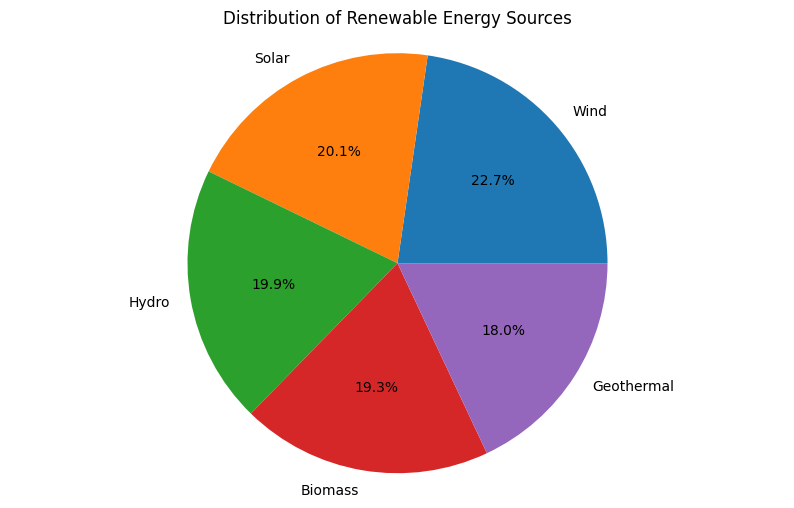

In [9]:
plt.figure(figsize=(10, 6))
energy_counts = df['Energy_Source'].value_counts()
plt.pie(energy_counts.values, labels=energy_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Renewable Energy Sources')
plt.axis('equal')
plt.show()

#Monthly Usage Visuals

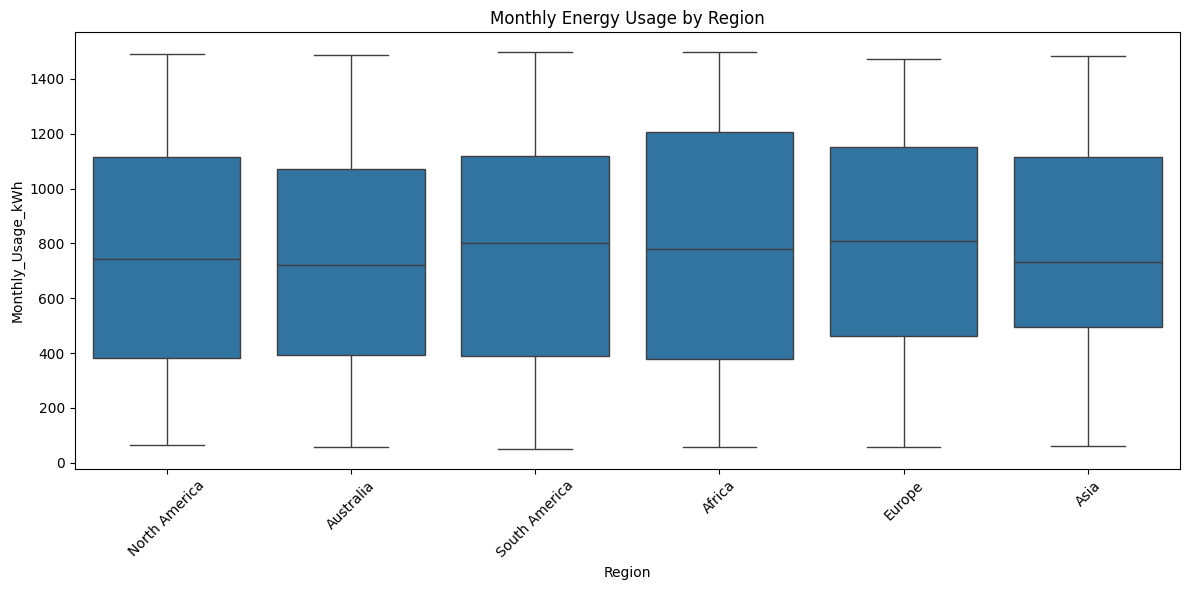

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Region', y='Monthly_Usage_kWh', data=df)
plt.title('Monthly Energy Usage by Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Household size vs Usage(monthly)

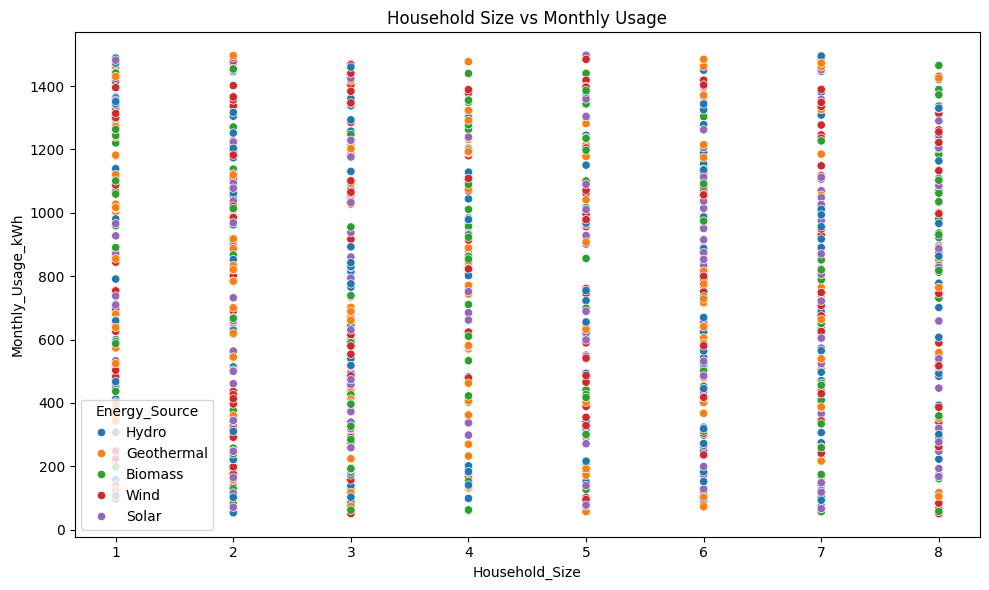

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Household_Size', y='Monthly_Usage_kWh', hue='Energy_Source')
plt.title('Household Size vs Monthly Usage')
plt.tight_layout()
plt.show()


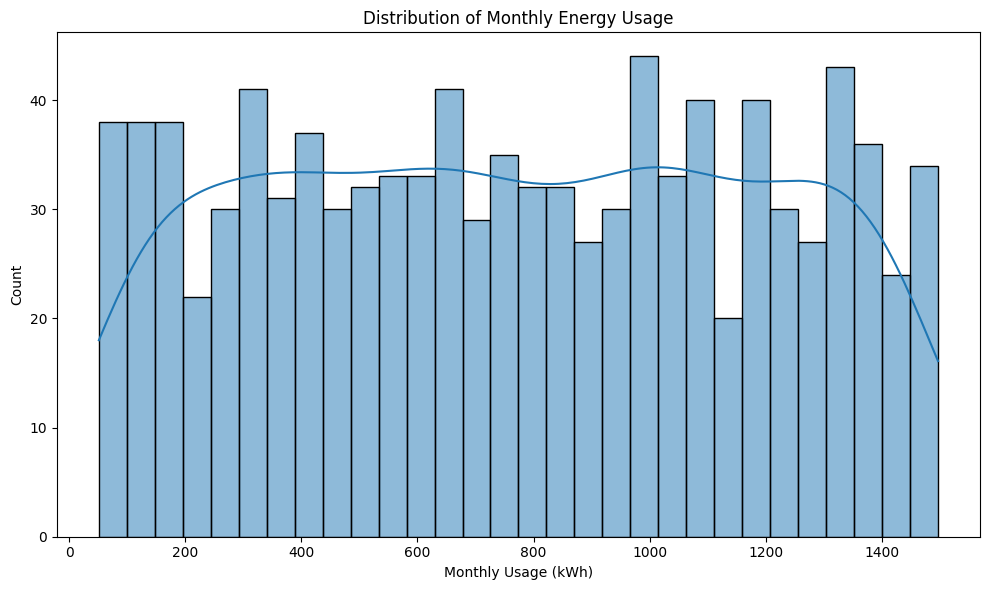

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Monthly_Usage_kWh', bins=30, kde=True)
plt.title('Distribution of Monthly Energy Usage')
plt.xlabel('Monthly Usage (kWh)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Comparing other factors

In [13]:
fig1 = px.box(df,
              x='Urban_Rural',
              y='Monthly_Usage_kWh',
              color='Income_Level',
              title='Energy Usage by Location and Income Level',
              labels={'Monthly_Usage_kWh': 'Monthly Usage (kWh)',
                     'Urban_Rural': 'Location Type',
                     'Income_Level': 'Income Level'})
fig1.show()

#Cost saving Analysis

In [14]:
fig2 = px.scatter(df,
                 x='Monthly_Usage_kWh',
                 y='Cost_Savings_USD',
                 color='Energy_Source',
                 size='Household_Size',
                 hover_data=['Region', 'Income_Level'],
                 title='Cost Savings vs Monthly Usage by Energy Source')
fig2.show()

#Adoption Trends Over Time

In [15]:
yearly_adoption = df.groupby(['Adoption_Year', 'Energy_Source']).size().reset_index(name='count')
fig3 = px.line(yearly_adoption,
               x='Adoption_Year',
               y='count',
               color='Energy_Source',
               title='Renewable Energy Adoption Trends Over Time')
fig3.show()

#Regional Energy Source Distribution

In [16]:
region_energy = pd.crosstab(df['Region'], df['Energy_Source'])
fig4 = px.bar(region_energy,
              title='Energy Source Distribution by Region',
              barmode='stack')
fig4.show()

#Subsidies vs Savings

In [17]:
fig5 = px.violin(df,
                 x='Subsidy_Received',
                 y='Cost_Savings_USD',
                 color='Income_Level',
                 box=True,
                 title='Impact of Subsidies on Cost Savings by Income Level')
fig5.show()

In [18]:
df['Usage_Per_Person'] = df['Monthly_Usage_kWh'] / df['Household_Size']

# Efficiency Analysis by Region and Income
fig1 = px.box(df,
              x='Region',
              y='Usage_Per_Person',
              color='Income_Level',
              title='Energy Efficiency (Usage per Person) by Region and Income Level')
fig1.show()

#Cost-Benefit Analysis

In [19]:
df['ROI'] = (df['Cost_Savings_USD'] / df['Monthly_Usage_kWh']).round(3)

fig2 = px.scatter(df,
                 x='ROI',
                 y='Monthly_Usage_kWh',
                 color='Energy_Source',
                 facet_col='Urban_Rural',
                 title='Return on Investment Analysis by Location Type')
fig2.show()

#Age of Installation Analysis

In [20]:
df['Installation_Age'] = 2024 - df['Adoption_Year']

fig3 = px.scatter(df,
                 x='Installation_Age',
                 y='Cost_Savings_USD',
                 color='Energy_Source',
                 trendline="ols",
                 title='Impact of Installation Age on Cost Savings')
fig3.show()

In [21]:
fig4 = px.sunburst(df,
                   path=['Region', 'Income_Level', 'Energy_Source'],
                   title='Hierarchical View of Energy Adoption Patterns')
fig4.show()

In [22]:
df['Usage_Category'] = pd.qcut(df['Monthly_Usage_kWh'],
                             q=4,
                             labels=['Low', 'Medium', 'High', 'Very High'])

fig5 = px.treemap(df,
                  path=[px.Constant("all"), 'Usage_Category', 'Energy_Source', 'Income_Level'],
                  title='Usage Patterns Breakdown')
fig5.show()

#Subsidy Impact on Different Demographics

In [23]:
subsidy_impact = pd.pivot_table(df,
                              values='Cost_Savings_USD',
                              index=['Income_Level', 'Urban_Rural'],
                              columns='Subsidy_Received',
                              aggfunc='mean').round(2)

fig6 = go.Figure(data=[
    go.Heatmap(
        z=subsidy_impact.values,
        x=['No Subsidy', 'With Subsidy'],
        y=[f"{idx[0]} - {idx[1]}" for idx in subsidy_impact.index],
        colorscale='RdYlGn'
    )
])
fig6.update_layout(title='Average Cost Savings: Subsidy Impact Analysis')
fig6.show()

In [24]:
print("\nKey Statistical Insights:")
print("-" * 50)
print(f"Average Usage per Person: {df['Usage_Per_Person'].mean():.2f} kWh")
print(f"Most Efficient Region: {df.groupby('Region')['Usage_Per_Person'].mean().idxmin()}")
print(f"Most Cost-Effective Energy Source: {df.groupby('Energy_Source')['ROI'].mean().idxmax()}")
print(f"Subsidy Impact: {(df[df['Subsidy_Received']=='Yes']['Cost_Savings_USD'].mean() - df[df['Subsidy_Received']=='No']['Cost_Savings_USD'].mean()):.2f} USD average increase")


Key Statistical Insights:
--------------------------------------------------
Average Usage per Person: 268.01 kWh
Most Efficient Region: Australia
Most Cost-Effective Energy Source: Wind
Subsidy Impact: -6.18 USD average increase


#MODEL BUILDING

In [25]:
columns_to_drop = ['Household_ID', 'Monthly_Usage_kWh', 'Usage_Per_Person', 'ROI', 'Usage_Category']
X = df.drop(columns=columns_to_drop)
y = df['Monthly_Usage_kWh']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns

In [26]:
encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    encoders[column] = le

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [30]:
y_pred = rf_model.predict(X_test_scaled)

In [31]:
print("\nModel Performance Metrics:")
print("-"*50)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")


Model Performance Metrics:
--------------------------------------------------
R2 Score: -0.0459
Mean Absolute Error: 372.6653
Root Mean Squared Error: 438.3234


In [32]:
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"\nCross-validation R2 scores: {cv_scores}")
print(f"Average CV R2 score: {cv_scores.mean():.4f}")


Cross-validation R2 scores: [-0.04108018 -0.07415565 -0.00431758 -0.12408522 -0.14132015]
Average CV R2 score: -0.0770


In [33]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

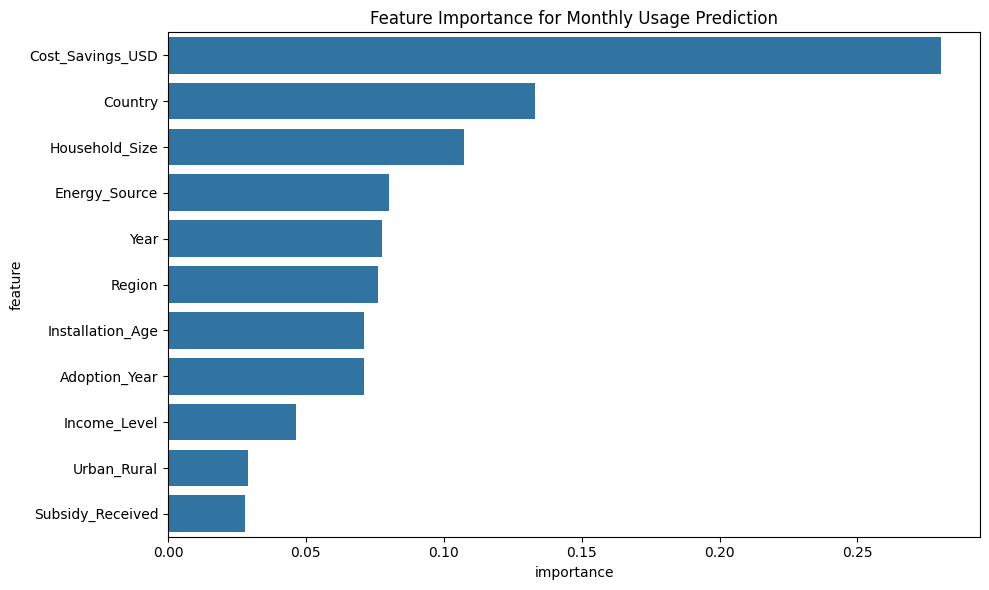

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Monthly Usage Prediction')
plt.tight_layout()
plt.show()

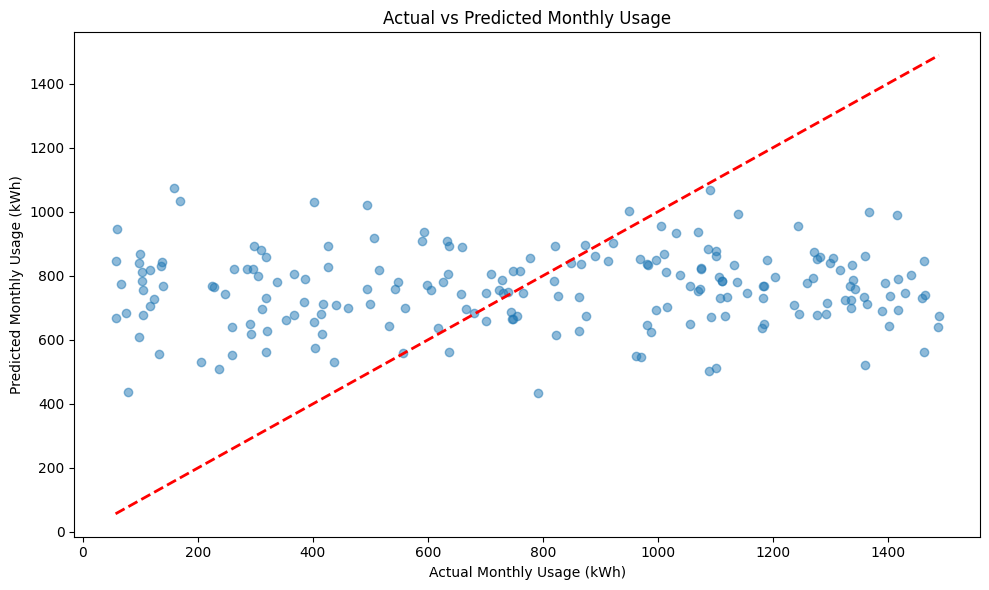

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Monthly Usage (kWh)')
plt.ylabel('Predicted Monthly Usage (kWh)')
plt.title('Actual vs Predicted Monthly Usage')
plt.tight_layout()
plt.show()

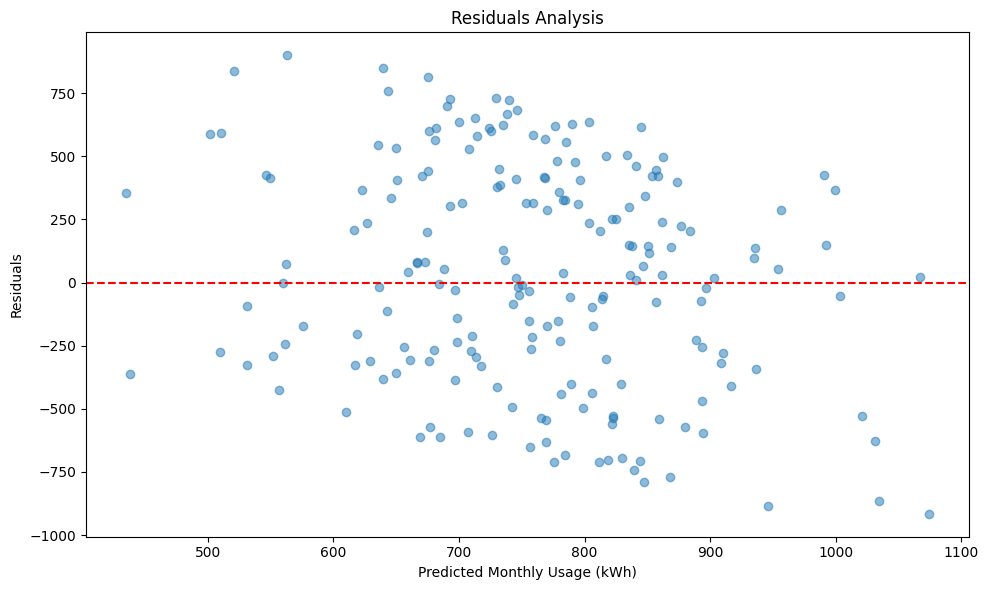

In [36]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Monthly Usage (kWh)')
plt.ylabel('Residuals')
plt.title('Residuals Analysis')
plt.tight_layout()
plt.show()

# XGBOOST
The random forest seems to not be the perfect model for thi data and so we will try XGboost!



In [37]:
def create_features(df):
    df = df.copy()

    # interaction features
    df['Usage_Efficiency'] = df['Cost_Savings_USD'] / df['Monthly_Usage_kWh']
    df['Years_Since_Adoption'] = df['Year'] - df['Adoption_Year']
    df['Household_Income_Impact'] = df['Household_Size'] * (df['Income_Level'].map({'Low': 1, 'Middle': 2, 'High': 3}))

    return df

In [38]:
columns_to_drop = ['Household_ID', 'Monthly_Usage_kWh', 'Usage_Per_Person', 'ROI', 'Usage_Category']
df_processed = create_features(df)
X = df_processed.drop(columns=columns_to_drop)
y = df_processed['Monthly_Usage_kWh']

In [39]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    encoders[column] = le

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

In [43]:
xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

In [44]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [45]:
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")


Best Parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Best Cross-Validation Score: 0.9767


In [46]:
best_model = grid_search.best_estimator_

# predictions
y_pred = best_model.predict(X_test_scaled)

In [47]:
print("\nModel Performance Metrics:")
print("-"*50)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")


Model Performance Metrics:
--------------------------------------------------
R2 Score: 0.9831
Mean Absolute Error: 33.5992
Root Mean Squared Error: 55.6793


In [48]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

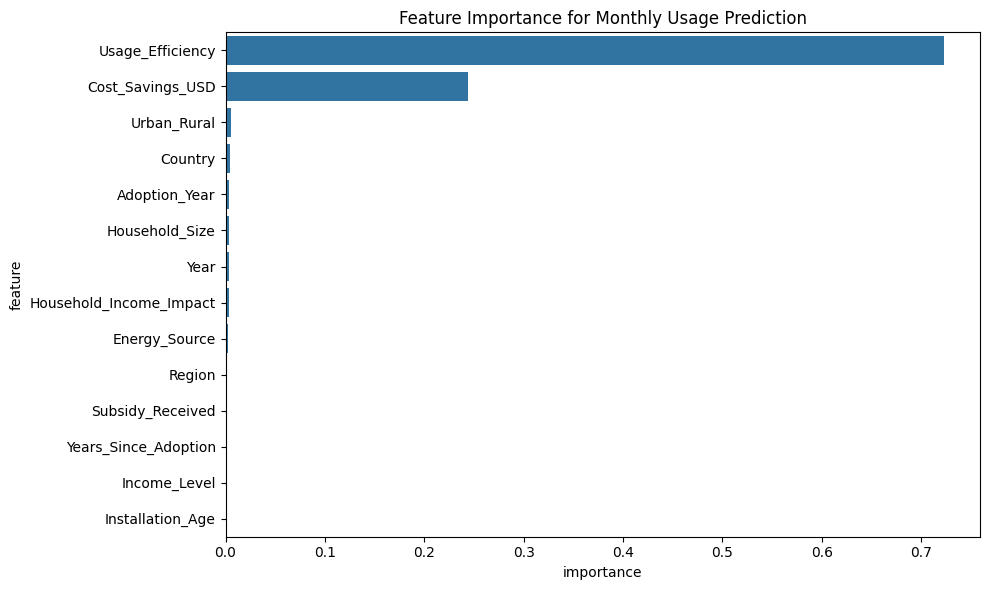

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Monthly Usage Prediction')
plt.tight_layout()
plt.show()


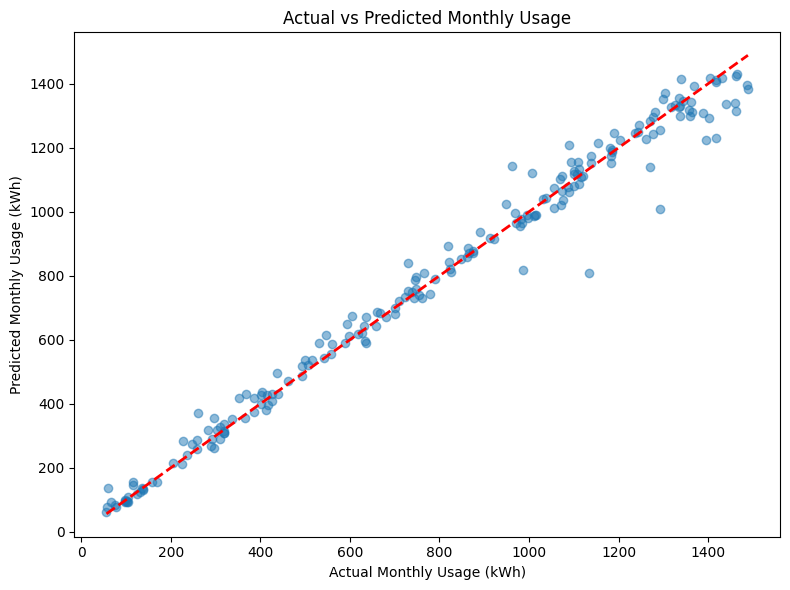

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Monthly Usage (kWh)')
plt.ylabel('Predicted Monthly Usage (kWh)')
plt.title('Actual vs Predicted Monthly Usage')
plt.tight_layout()
plt.show()

# Yay it works!
We observe that the data is better fitted with a much less RMSE than random forest. We can conclude that XGBoost is a better model for this data.